<a href="https://colab.research.google.com/github/marreapato/Forecasting_Paper_XAI/blob/main/antehoc/AttentionWeightsTrying.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Attention, Concatenate

# Download stock data using yfinance
symbol = "AAPL"
data = yf.download(symbol, start="2020-01-01", end="2022-01-01")
df = pd.DataFrame(data['Adj Close'])

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(df)

# Create sequences for training
sequence_length = 1
X, y = [], []
for i in range(len(df_scaled) - sequence_length):
    X.append(df_scaled[i:i+sequence_length])
    y.append(df_scaled[i+sequence_length])

X, y = np.array(X), np.array(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the model with attention mechanism
input_layer = Input(shape=(sequence_length, 1))
lstm_layer = LSTM(50, return_sequences=True)(input_layer)
attention = Attention()([lstm_layer, lstm_layer])
context = attention * lstm_layer
output_layer = Dense(1)(context)

# Concatenate the output and attention weights
model = Model(inputs=input_layer, outputs=[output_layer, attention])
model.compile(optimizer='adam', loss=['mean_squared_error', None])

# Train the model
model.fit(X_train, [y_train, np.zeros_like(y_train)], epochs=50, batch_size=32, validation_data=(X_test, [y_test, np.zeros_like(y_test)]))


[*********************100%%**********************]  1 of 1 completed


Epoch 1/50
13/13 [==============================] - 3s 50ms/step - loss: 0.2925 - dense_3_loss: 0.2925 - val_loss: 0.3120 - val_dense_3_loss: 0.3120
Epoch 2/50
13/13 [==============================] - 0s 6ms/step - loss: 0.2784 - dense_3_loss: 0.2784 - val_loss: 0.2977 - val_dense_3_loss: 0.2977
Epoch 3/50
13/13 [==============================] - 0s 7ms/step - loss: 0.2644 - dense_3_loss: 0.2644 - val_loss: 0.2833 - val_dense_3_loss: 0.2833
Epoch 4/50
13/13 [==============================] - 0s 7ms/step - loss: 0.2503 - dense_3_loss: 0.2503 - val_loss: 0.2683 - val_dense_3_loss: 0.2683
Epoch 5/50
13/13 [==============================] - 0s 7ms/step - loss: 0.2356 - dense_3_loss: 0.2356 - val_loss: 0.2519 - val_dense_3_loss: 0.2519
Epoch 6/50
13/13 [==============================] - 0s 6ms/step - loss: 0.2192 - dense_3_loss: 0.2192 - val_loss: 0.2341 - val_dense_3_loss: 0.2341
Epoch 7/50
13/13 [==============================] - 0s 7ms/step - loss: 0.2014 - dense_3_loss: 0.2014 - val_los

In [24]:
# Predict on the test set
predictions, attention_weights = model.predict(X_test)


4/4 [==============================] - 0s 4ms/step


In [47]:
train_predictions, train_attention_weights = model.predict(X_train)


13/13 [==============================] - 0s 2ms/step


In [48]:
train_attention_weights[:,:,0].shape

(403, 1)

In [27]:
y_train.shape

(403, 1)

In [28]:
attention_weights.shape

(101, 1, 50)

In [29]:
predictions.reshape(-1,1).shape

(101, 1)

In [30]:
y_test.shape

(101, 1)

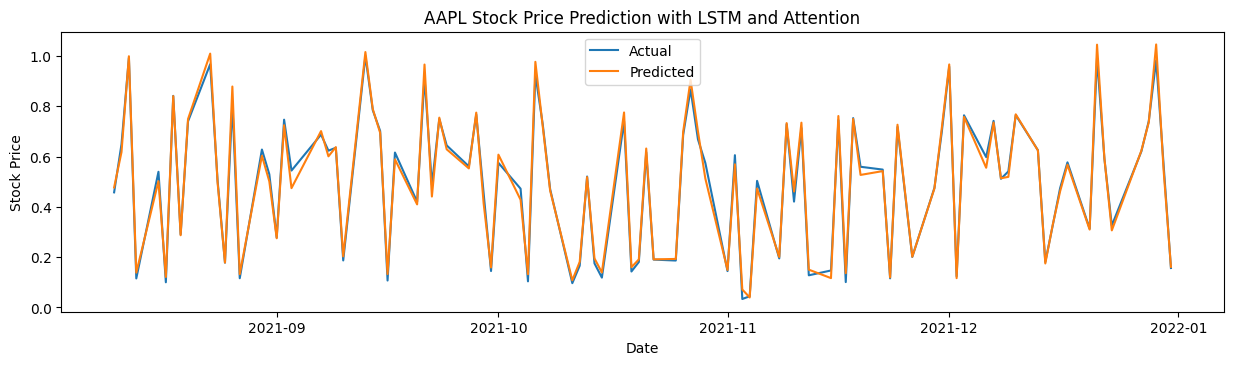

In [49]:
## Inverse transform the predictions and actual values to get them in the original scale
##predictions = scaler.inverse_transform(predictions)
#y_test_original = scaler.inverse_transform(y_test)

# Plot the results
plt.figure(figsize=(15, 8))

# Plotting actual vs predicted stock prices
plt.subplot(2, 1, 1)
plt.plot(df.index[-len(y_test):], y_test, label='Actual')
plt.plot(df.index[-len(predictions):], predictions.reshape(-1,1), label='Predicted')
plt.title(f'{symbol} Stock Price Prediction with LSTM and Attention')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()



IndexError: index 1 is out of bounds for axis 1 with size 1

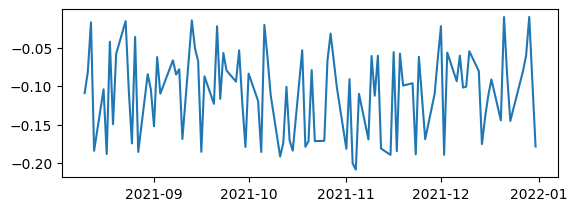

In [50]:
# Plotting attention weights
plt.subplot(2, 1, 2)
for i in range(5):  # Plot attention weights for the first 5 samples in the test set
    plt.plot(df.index[-len(attention_weights):], attention_weights[:, i, 0], label=f'Sample {i + 1}')

plt.title('Attention Weights')
plt.xlabel('Date')
plt.ylabel('Attention Weight')
plt.legend()

plt.tight_layout()
plt.show()


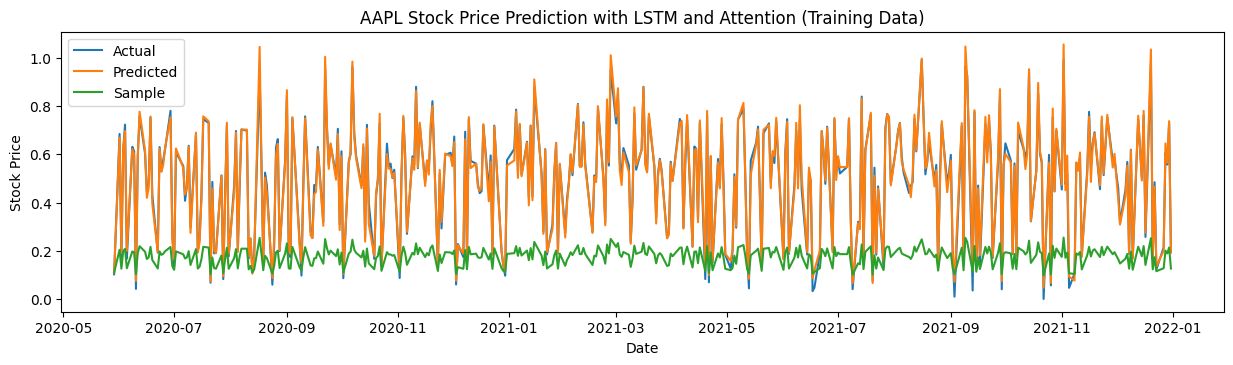

In [55]:
# Plot the attention weights for the training data
plt.figure(figsize=(15, 8))

# Plotting actual vs predicted stock prices
plt.subplot(2, 1, 1)
plt.plot(df.index[-len(y_train):], y_train, label='Actual')
plt.plot(df.index[-len(train_predictions):], train_predictions.reshape(-1,1), label='Predicted')
plt.plot( df.index[-len(train_attention_weights):], train_attention_weights[:,:,49], label='Sample')
plt.title(f'{symbol} Stock Price Prediction with LSTM and Attention (Training Data)')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()



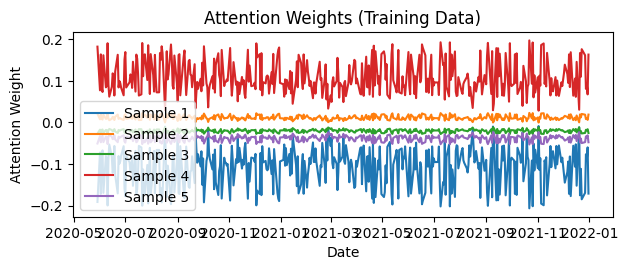

In [53]:
# Plotting attention weights for the training data
plt.subplot(2, 1, 2)
for i in range(5):  # Plot attention weights for the first 5 samples in the training set
    plt.plot(df.index[-len(train_attention_weights):], train_attention_weights[:, :, i], label=f'Sample {i + 1}')

plt.title('Attention Weights (Training Data)')
plt.xlabel('Date')
plt.ylabel('Attention Weight')
plt.legend()


plt.tight_layout()
plt.show()